In [1]:


import sys
sys.path.append("../mbt_gym/")

import matplotlib.pyplot as plt
import numpy as np
import random
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.agents.BaselineAgents import RandomAgent, FixedSpreadAgent, AvellanedaStoikovAgent, CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.plotting import generate_trajectory, generate_results_table_and_hist, plot_trajectory
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.agents.PolicyGradientAgent import PolicyGradientAgent
from mbt_gym.stochastic_processes.midprice_models import ConstantMidpriceModel

from mbt_gym_backtest import *




The `mbt-gym` `TradingEnvironment` contains three main models (for market making):

- **arrival_model**: Simulates the arrival of a market order. (Poisson, Hawkes)
- **fill_probability_model**: Simulates the fact that the further we are from the midprice, the lower the probability of being executed. (Exponential, Triangular, Power)
- **midprice_model**: A random process that simulates the evolution of the price. (Constant, Brownian...)

At each time step, the agent chooses a `bid_spread` and `ask_spread` in $[0, \text{max\_depth}]$, it can also choose to make a market order in models that allow it, then place a buy order at the price `midprice - bid_spread` and a sell order at the price `midprice + ask_spread`. The orders are executed with the probability `fill_probability * arrival_probability` for the bid and ask orders, respectively.

#### Improvements:

- Using a multidimensional Hawkes process to simulate the arrival at each price.
- Implement a queuing process.
- Add a latency model/fee model.
- Add a dynamic order quantity.



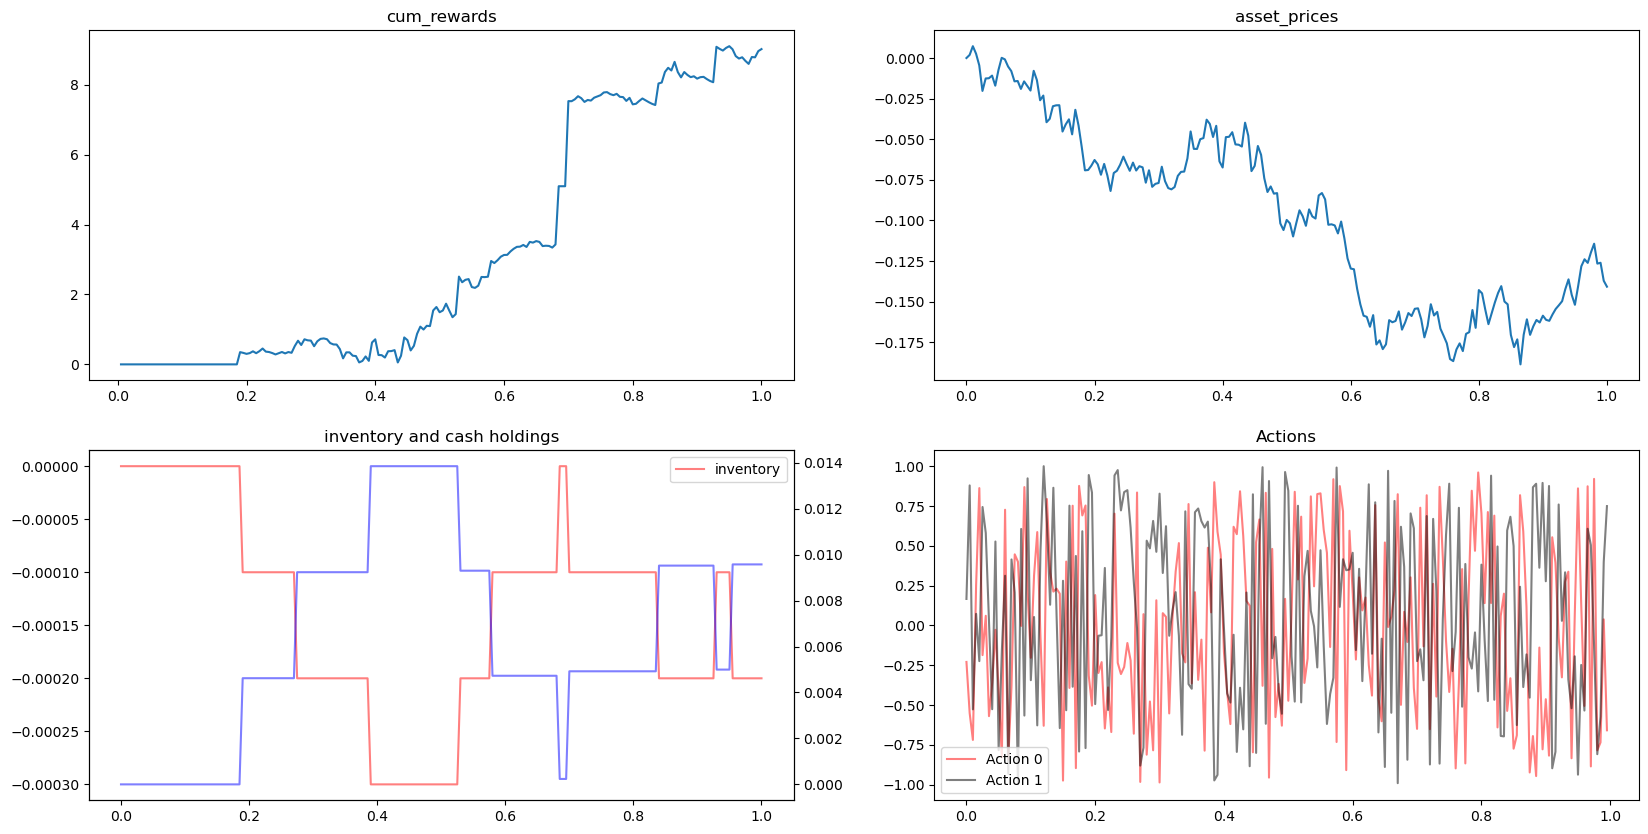

In [2]:
terminal_time = 1.0
n_steps = 200
seed = 42
np.random.seed(seed)

step_size = 0.001
intensity = np.array([140, 140])

fill_exponent = 1.5

arrival_model = PoissonArrivalModel(intensity=intensity, step_size=step_size, seed=seed)
fill_probability_model = ExponentialFillFunction(fill_exponent, step_size=step_size, seed=seed)
midprice_model = BrownianMotionMidpriceModel(step_size=step_size, seed=seed)

model_dynamics = LimitOrderModelDynamics(midprice_model=midprice_model, arrival_model=arrival_model, fill_probability_model=fill_probability_model)

env = TradingEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=seed, model_dynamics=model_dynamics)
agent = RandomAgent(env)
plot_trajectory(env, agent, seed = seed)


In order to do backtesting on real data, I have implemented new classes that are useful to work with the `hftbacktest` library:

- **`class HistoricalMidpriceModel(StochasticProcessModel)`**: A midprice model that uses historical data.
- **`class BackTestingLimitOrderModelDynamics(ModelDynamics)`** and **`class BackTestingTradingEnvironment(TradingEnvironment)`**: These classes allow backtesting of the `LimitOrderModelDynamics` class (which does not allow market orders) by taking feedback from the `hftbacktest` simulation (specifically the information indicating whether the order has been executed).

To backtest our models, we could perform parameter estimation on training data (from real market data) and test the effectiveness of the agent's strategy on test data.


## Historical midprice model

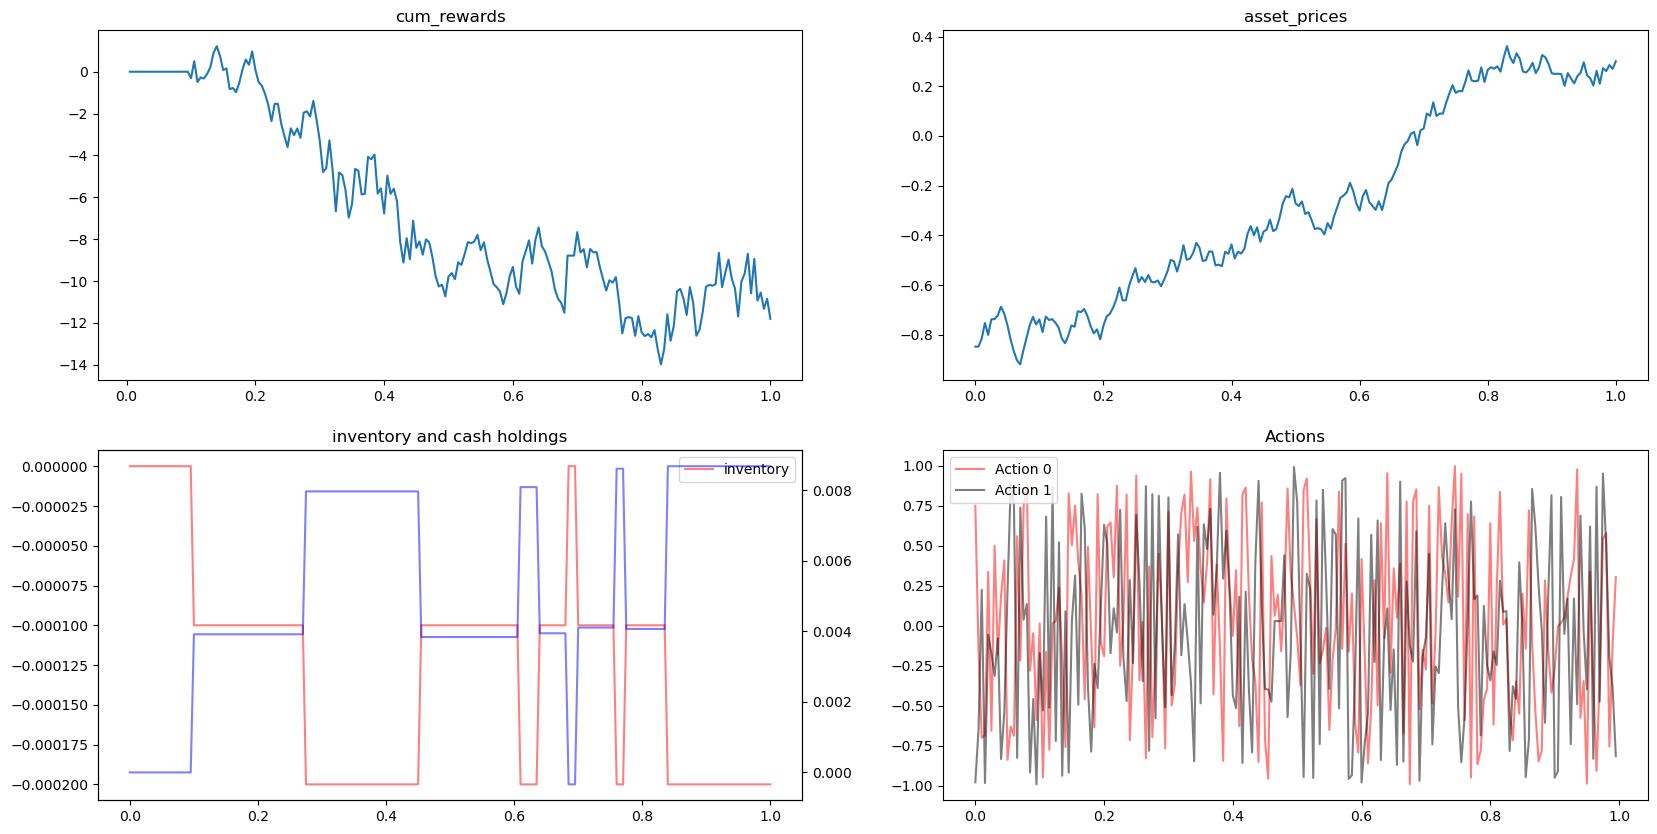

In [3]:

def generate_random_prices(n, midprice, volatility=0.01):
    prices = [midprice]
    for _ in range(n - 1):
        change = midprice * random.uniform(-volatility, volatility)
        new_price = prices[-1] + change
        prices.append(new_price)
    return prices

n_prices = int(terminal_time/step_size)
random_prices = generate_random_prices(n_prices, midprice=100.0, volatility=0.01)

terminal_time = 1.0
n_steps = 200
seed = 42
step_size = 0.001
np.random.seed(seed)

intensity = np.array([140, 140])
fill_exponent = 1.5

arrival_model = PoissonArrivalModel(intensity=intensity, step_size=step_size, seed=seed)
fill_probability_model = ExponentialFillFunction(fill_exponent, step_size=step_size, seed=seed)
midprice_model = HistoricalMidpriceModel(midprice_list=random_prices, step_size=step_size, seed=seed)
model_dynamics = LimitOrderModelDynamics(midprice_model=midprice_model, arrival_model=arrival_model, fill_probability_model=fill_probability_model)

env = TradingEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=seed, model_dynamics=model_dynamics)
agent = RandomAgent(env)

plot_trajectory(env, agent, seed = seed)